In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import pickle

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [4]:
final_data = pd.read_csv('/content/drive/MyDrive/Load Forcasting/Load ForcastingProject/FeatureEngineeringOnGreatBritianElectricityConsumption.csv')

In [5]:
#-> Converting to date time format
final_data['settlement_date'] = pd.to_datetime(final_data['settlement_date'])
final_data.set_index('settlement_date', inplace=True)

final_data = final_data.fillna(value=final_data['nd'].mean())

# Converting textual data to numerical data

for col in ['timeofday','season']:
    if col in final_data.columns:
        one_hot_encoded = pd.get_dummies(final_data[col], prefix=col)
        final_data = final_data.drop(col, axis=1)
        final_data = pd.concat([final_data, one_hot_encoded], axis=1)

# Converting boolian values to numericAL values

for col in final_data.columns:
    if final_data[col].dtype == 'bool':
        final_data[col] = final_data[col].astype(int)


In [6]:
final_data.drop(columns=['month',
       'hour_of_day', 'day_of_week','timeofday_Afternoon', 'season_Autumn'], inplace=True)

In [7]:
X_data = final_data[[
     'embedded_wind_generation',
     'embedded_solar_generation',
     'wind + solar generation',
      'year', 'weekend',
       'hour_of_day_x', 'hour_of_day_y', 'week_x', 'week_y', 'month_x',
       'month_y', 'demand_diff', 'wind_diff', 'solar_diff', 'rolling_mean_24',
       'rolling_std_24', 'rolling_mean_48', 'rolling_std_48', 'load_lag_1',
       'load_lag_2', 'load_lag_3', 'load_lag_4', 'load_lag_5', 'load_lag_6',
       'load_lag_48', 'timeofday_Evening', 'timeofday_Morning',
       'timeofday_Night', 'season_Spring', 'season_Summer', 'season_Winter']]

y_data = final_data['nd']


In [ ]:
# X_train = X_data.iloc[:262195] #-> 14 years of data(2009 - 2023)
# X_test = X_data.iloc[262195:262867]  #-> 2 weeks value (2023 - 2024)

# y_train = y_data.iloc[:262195]
# y_test = y_data.iloc[262195:262867]



# **Testing Data**

In [8]:
Prediction_Data = pd.read_csv('/content/drive/MyDrive/Load Forcasting/Load ForcastingProject/prediction_data_2025.csv')

In [5]:
Prediction_Data['settlement_date'] = pd.to_datetime(Prediction_Data['settlement_date'])
Prediction_Data.set_index('settlement_date', inplace=True)

Prediction_Data = Prediction_Data.fillna(value=Prediction_Data['nd'].mean())

Prediction_Data.drop(columns=['embedded_wind_generation', 'embedded_solar_generation',
       'wind + solar generation', 'total_consumption', 'month',
       'hour_of_day', 'day_of_week', 'wind_diff', 'solar_diff', ], inplace=True)

for col in ['timeofday']:

    if col in Prediction_Data.columns:

        one_hot_encoded = pd.get_dummies(Prediction_Data[col], prefix=col)
        Prediction_Data = Prediction_Data.drop(col, axis=1)
        Prediction_Data = pd.concat([Prediction_Data, one_hot_encoded], axis=1)

for col in Prediction_Data.columns:

    if Prediction_Data[col].dtype == 'bool':
        Prediction_Data[col] = Prediction_Data[col].astype(int)

season_col = Prediction_Data[['season_Autumn',
       'season_Spring', 'season_Summer', 'season_Winter']]

Prediction_Data.drop(columns=['season_Winter', 'season_Spring',
       'season_Summer', 'season_Autumn'] , inplace=True)

Prediction_Data = pd.concat((Prediction_Data,season_col), axis=1 )

X_data_pred = Prediction_Data[['year', 'weekend', 'hour_of_day_x', 'hour_of_day_y', 'week_x',
       'week_y', 'month_x', 'month_y', 'demand_diff', 'rolling_mean_24',
       'rolling_std_24', 'rolling_mean_48', 'rolling_std_48', 'load_lag_1',
       'load_lag_2', 'load_lag_3', 'load_lag_4', 'load_lag_5', 'load_lag_6',
       'load_lag_7', 'load_lag_8', 'load_lag_9', 'load_lag_10', 'load_lag_11',
       'load_lag_12', 'load_lag_13', 'load_lag_14', 'load_lag_15',
       'load_lag_16', 'load_lag_17', 'load_lag_18', 'load_lag_19',
       'load_lag_20', 'load_lag_21', 'load_lag_22', 'load_lag_23',
       'load_lag_24', 'timeofday_Evening',
       'timeofday_Morning', 'timeofday_Night',
       'season_Spring', 'season_Summer', 'season_Winter']]

y_data_pred = Prediction_Data['nd']

X_test_pred01 = X_data_pred.iloc[:672]
y_test_pred01 = y_data_pred.iloc[:672]

In [6]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.6 MB/s eta 0:00:00


In [7]:
def load_model(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

LR = load_model('/content/drive/MyDrive/LR.pkl')
ridge = load_model('/content/drive/MyDrive/Ridge.pkl')
Lasso = load_model('/content/drive/MyDrive/Lasso.pkl')
ElasticNet = load_model('/content/drive/MyDrive/ElasticNet.pkl')
# DT = load_model('/content/drive/MyDrive/TraunDT.pkl')

rf = load_model('/content/drive/MyDrive/RF.pkl')
AdaBoost = load_model('/content/drive/MyDrive/AdaBoost.pkl')
GB = load_model('/content/drive/MyDrive/GradientBoost.pkl')
xgb = load_model('/content/drive/MyDrive/XGBoost.pkl')
LightGB = load_model('/content/drive/MyDrive/LightGradientBoost.pkl')
CatBoost = load_model('/content/drive/MyDrive/CatGradientBoost.pkl')

# Voting = load_model('/content/drive/MyDrive/Voting.pkl')
# Stacking = load_model('/content/drive/MyDrive/Stacking.pkl')
# Blending = load_model('/content/drive/MyDrive/Blending.pkl')

In [8]:
LR_model = LR.predict(X_test_pred01)
ridge_model = ridge.predict(X_test_pred01)
Lasso_model = Lasso.predict(X_test_pred01)
ElasticNet_model = ElasticNet.predict(X_test_pred01)
# DT_model = DT.predict(X_test)

rf_model = rf.predict(X_test_pred01)
AdaBoost_model = AdaBoost.predict(X_test_pred01)
GB_model = GB.predict(X_test_pred01)
xgb_model = xgb.predict(X_test_pred01)
LightGB_model = LightGB.predict(X_test_pred01)
CatBoost_model = CatBoost.predict(X_test_pred01)

# Voting_model = Voting.predict(X_test_pred01)
# Stacking_model = Stacking.predict(X_test_pred01)
# Blending_model = Blending.predict(X_test_pred01)

In [23]:
# actual = y_test_pred01
# pred = pd.DataFrame(LightGB_model)
# actual.head(10)

In [12]:
# --- Calculate metrics and store them ---
results = []

models_and_predictions = {
    "Linear Regression": LR_model,
    "Ridge Regression": ridge_model,
    "Lasso Regression": Lasso_model,
    "ElasticNet Regression": ElasticNet_model,
    # "Decision Tree": DT_preds,
    "Random Forest": rf_model,
    "AdaBoost Regressor": AdaBoost_model,
    "Gradient Boosting Regressor": GB_model,
    "XGBoost Regressor": xgb_model,
    "LightGBM Regressor": LightGB_model,
    "CatBoost Regressor": CatBoost_model
    # "Voting Regressor": Voting_model,
    # "Stacking Regressor": Stacking_model,
    # "Blending Regressor": Blending_model
}

for model_name, predictions in models_and_predictions.items():
    mae = mean_absolute_error(y_test_pred01, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_pred01, predictions))
    r2 = r2_score(y_test_pred01, predictions)
    results.append({
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

In [13]:
# Create a Pandas DataFrame for the comparison table
comparison_df = pd.DataFrame(results)

# Sort by R2 score (or any other metric you prefer)
comparison_df = comparison_df.sort_values(by='R2', ascending=False)

print("\n--- Model Performance Comparison Table ---")
print(comparison_df.round(4)) # Round to 4 decimal places for cleaner output



--- Model Performance Comparison Table ---
                         Model       MAE       RMSE      R2
8           LightGBM Regressor  120.0792   551.7503  0.9933
7            XGBoost Regressor   98.0858   593.1872  0.9923
9           CatBoost Regressor  102.8661   593.9852  0.9923
4                Random Forest   33.0353   612.9817  0.9918
6  Gradient Boosting Regressor   82.6447   636.3940  0.9911
5           AdaBoost Regressor  869.9395  1163.7088  0.9703
0            Linear Regression   97.6099  1583.5645  0.9451
1             Ridge Regression   97.5859  1583.5715  0.9451
2             Lasso Regression  365.5688  2424.2434  0.8713
3        ElasticNet Regression  367.0373  2440.5676  0.8696


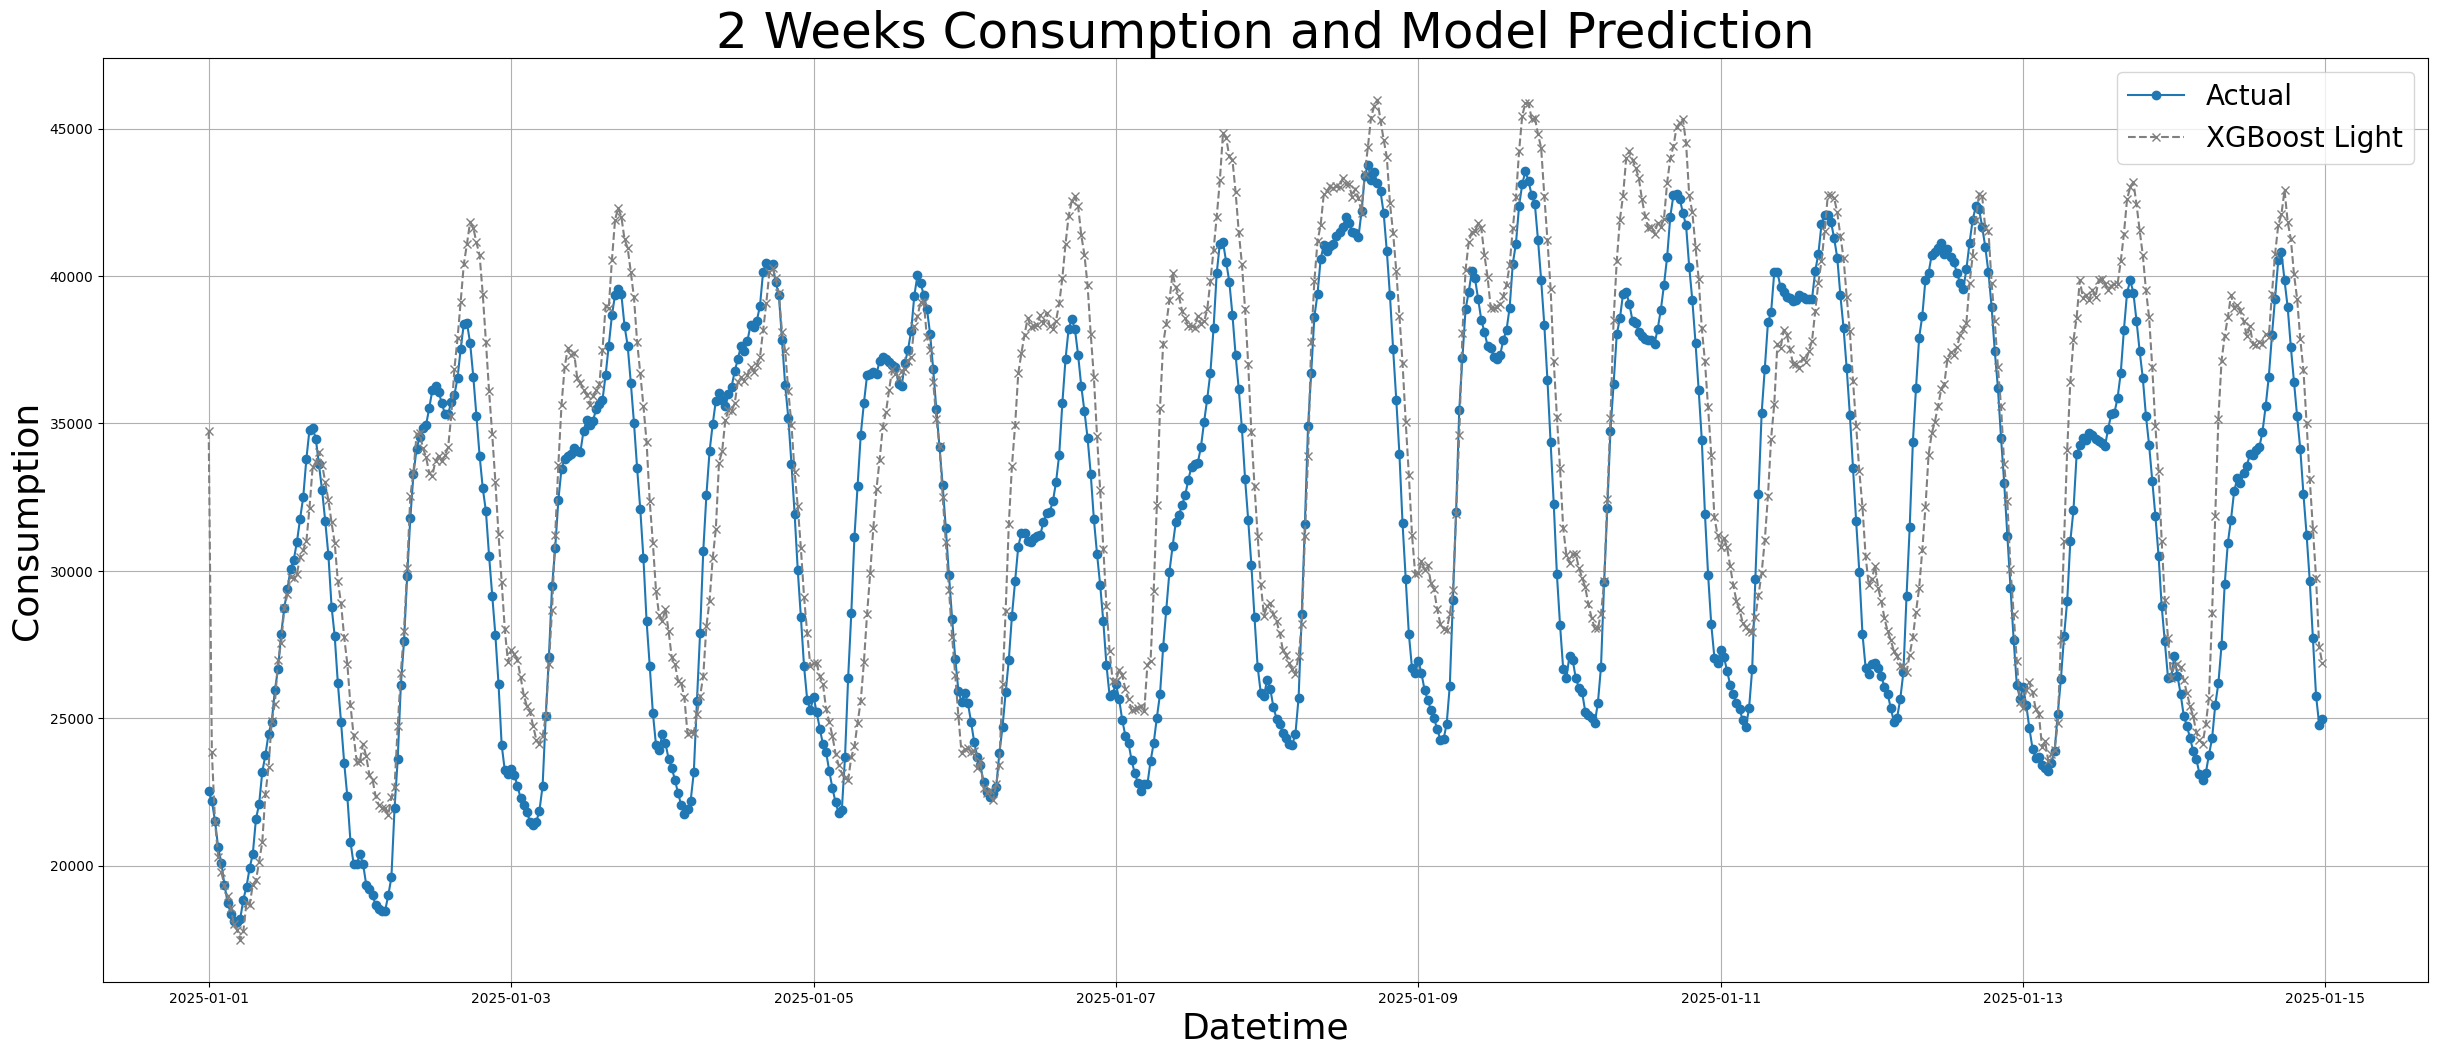

In [14]:
plt.figure(figsize=(30, 12))

# Plot actual values
plt.plot(y_test_pred01.index, y_test, marker='o', label='Actual')

# Plot LR predictions with same index
# plt.plot(y_test_pred01.index, LR_model, label='Linear Regression', linestyle='--', color='red', marker='x')
# plt.plot(y_test_pred01.index, ridge_model, label='Ridge Regression', linestyle='--', color='yellow', marker='x')
# plt.plot(y_test_pred01.index, Lasso_model, label='Lasso Regression', linestyle='--', color='black', marker='x')
# plt.plot(y_test_pred01.index, ElasticNet_model, label='ElasticNet Regression', linestyle='--', color='green', marker='x')
# plt.plot(y_test_pred01.index, AdaBoost_model, label='AdaBoost', linestyle='--', color='purple', marker='x')
# plt.plot(y_test_pred01.index, GB_model, label='Gradient Boost', linestyle='--', color='orange', marker='x')
# plt.plot(y_test_pred01.index, xgb_model, label='XGBoost', linestyle='--', color='brown', marker='x')
plt.plot(y_test_pred01.index, LightGB_model, label='XGBoost Light', linestyle='--', color='gray', marker='x')
# plt.plot(y_test_pred01.index, CatBoost_model, label='Cat Boost', linestyle='--', color='red', marker='x')
# plt.plot(y_test_pred01.index, rf_model, label='Random Forest', linestyle='--', color='yellow', marker='o')
# plt.plot(y_test_pred01.index, Voting_model, label='Voting', linestyle='--', color='black', marker='x')

plt.title('2 Weeks Consumption and Model Prediction', fontsize=36)
plt.xlabel('Datetime' , fontsize=26)
plt.ylabel('Consumption', fontsize=26)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()

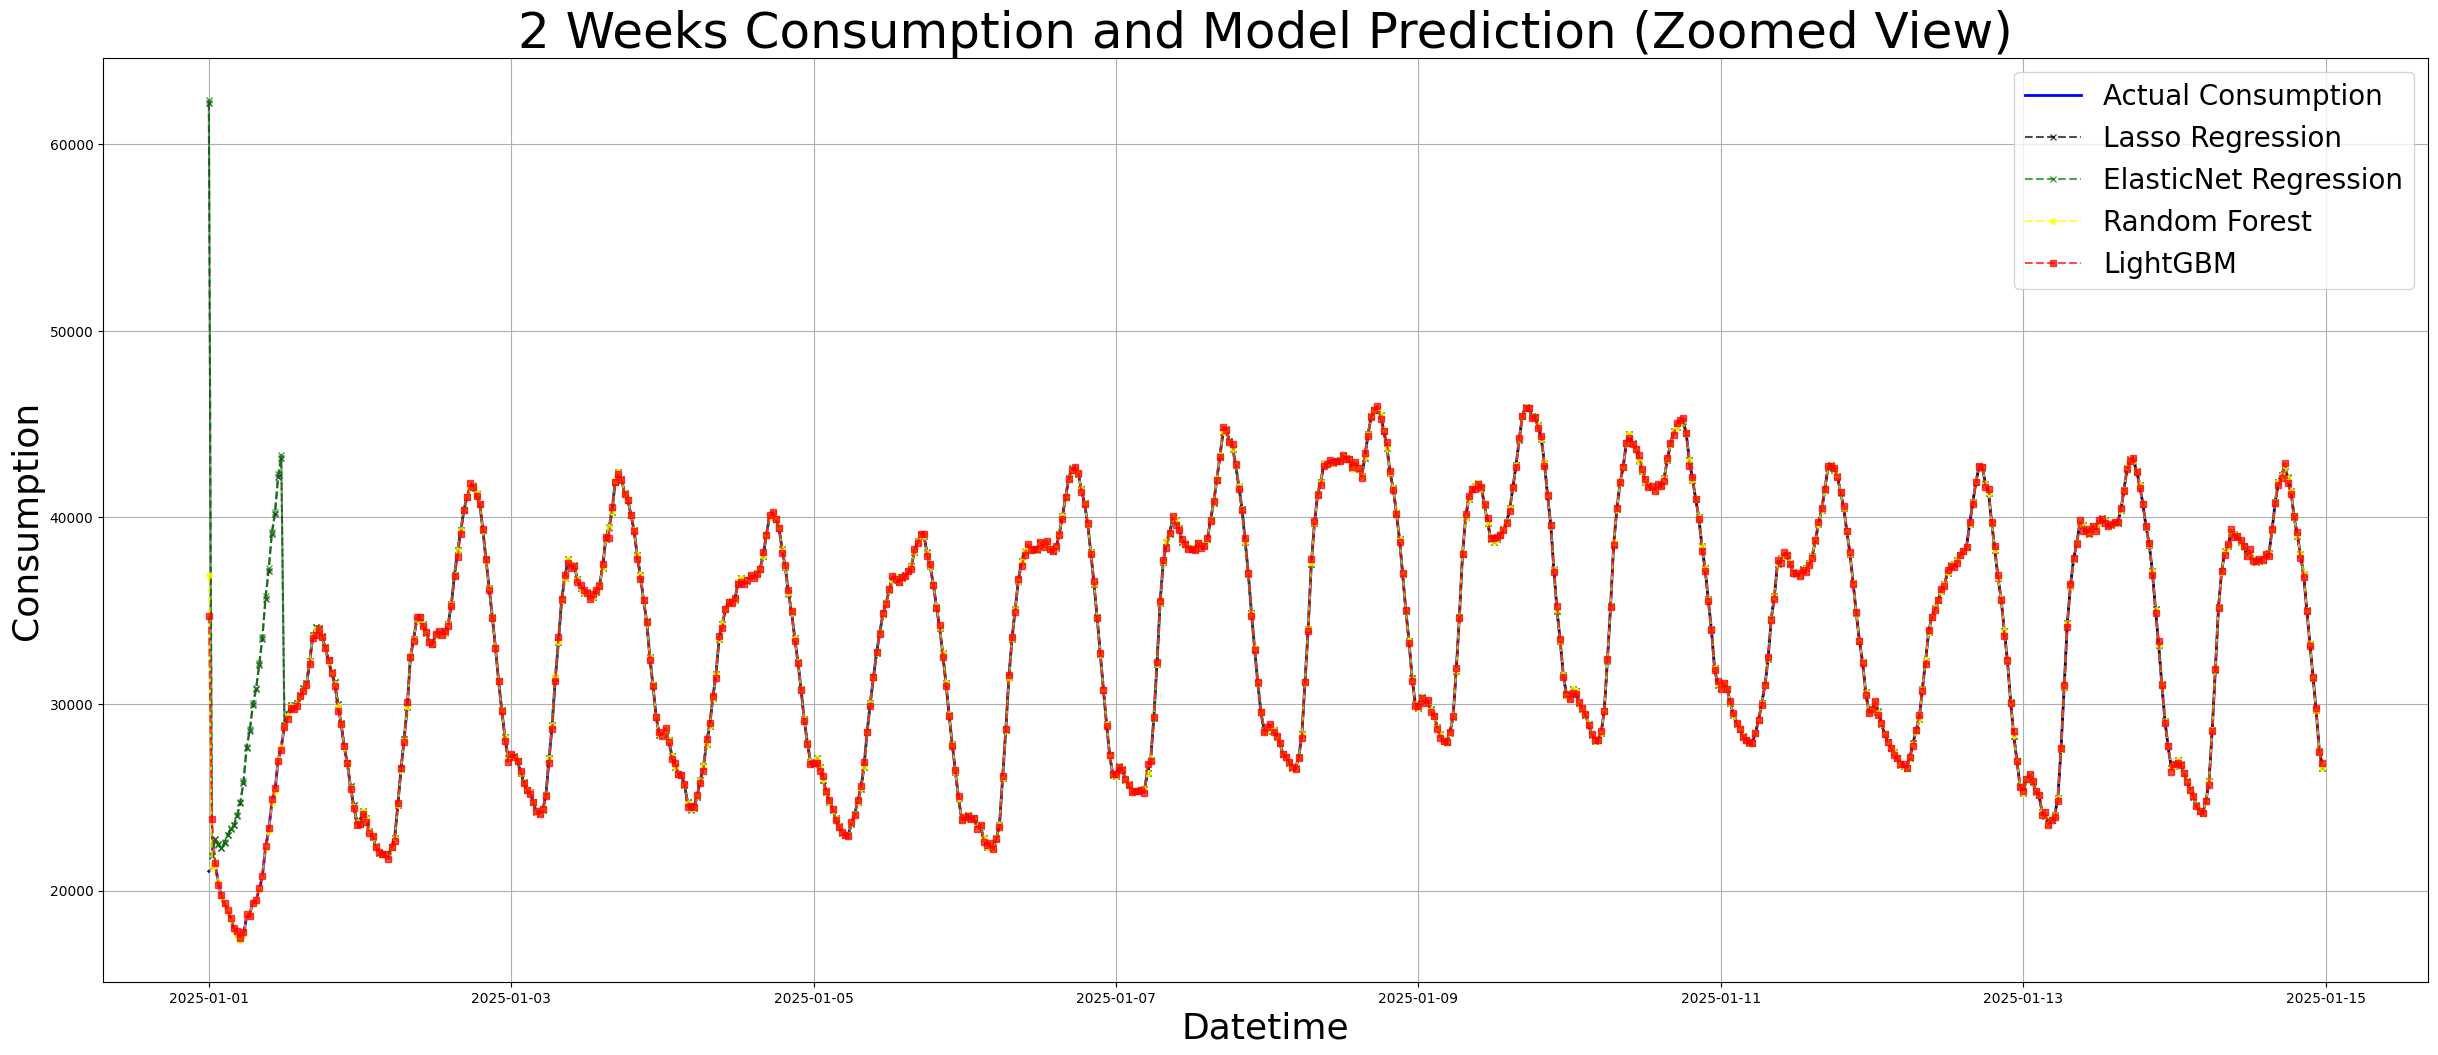

In [21]:
import matplotlib.pyplot as plt
import pandas as pd # Assuming y_test is a pandas Series/DataFrame

# Assuming y_test, Lasso_model, ElasticNet_model, rf_model etc., are defined
# and that Lasso_model, ElasticNet_model, rf_model are INVERSED-SCALED predictions

# --- Option 1: Plot Actuals and Predictions with Zoomed Y-axis ---
plt.figure(figsize=(30, 12))
plt.plot(y_test_pred01.index, y_test_pred01, label='Actual Consumption', color='blue', linewidth=2) # Plot actuals first

# Plot your desired model predictions
plt.plot(y_test_pred01.index, Lasso_model, label='Lasso Regression', linestyle='--', color='black', marker='x', markersize=4, alpha=0.7)
plt.plot(y_test_pred01.index, ElasticNet_model, label='ElasticNet Regression', linestyle='--', color='green', marker='x', markersize=4, alpha=0.7)
plt.plot(y_test_pred01.index, rf_model, label='Random Forest', linestyle='--', color='yellow', marker='o', markersize=4, alpha=0.7)
plt.plot(y_test_pred01.index, LightGB_model, label='LightGBM', linestyle='--', color='red', marker='s', markersize=4, alpha=0.7) # Add LightGBM for comparison

plt.title('2 Weeks Consumption and Model Prediction (Zoomed View)', fontsize=36)
plt.xlabel('Datetime', fontsize=26)
plt.ylabel('Consumption', fontsize=26)
plt.legend(fontsize=20)
plt.grid(True)

# --- KEY CHANGE: Adjust Y-axis limits to a narrow range ---
# You'll need to inspect your data to find a good range.
# For example, if your consumption is around 20,000, and errors are 500,
# you might set a range like this around an average value:
# plt.ylim(y_test.mean() - 1000, y_test.mean() + 1000)
# OR, pick a peak/trough area and zoom there.
# Let's say your data ranges from 10000 to 50000. Try focusing on a smaller range.
# Example: plt.ylim(20000, 22000) # Adjust based on your actual data
plt.show()


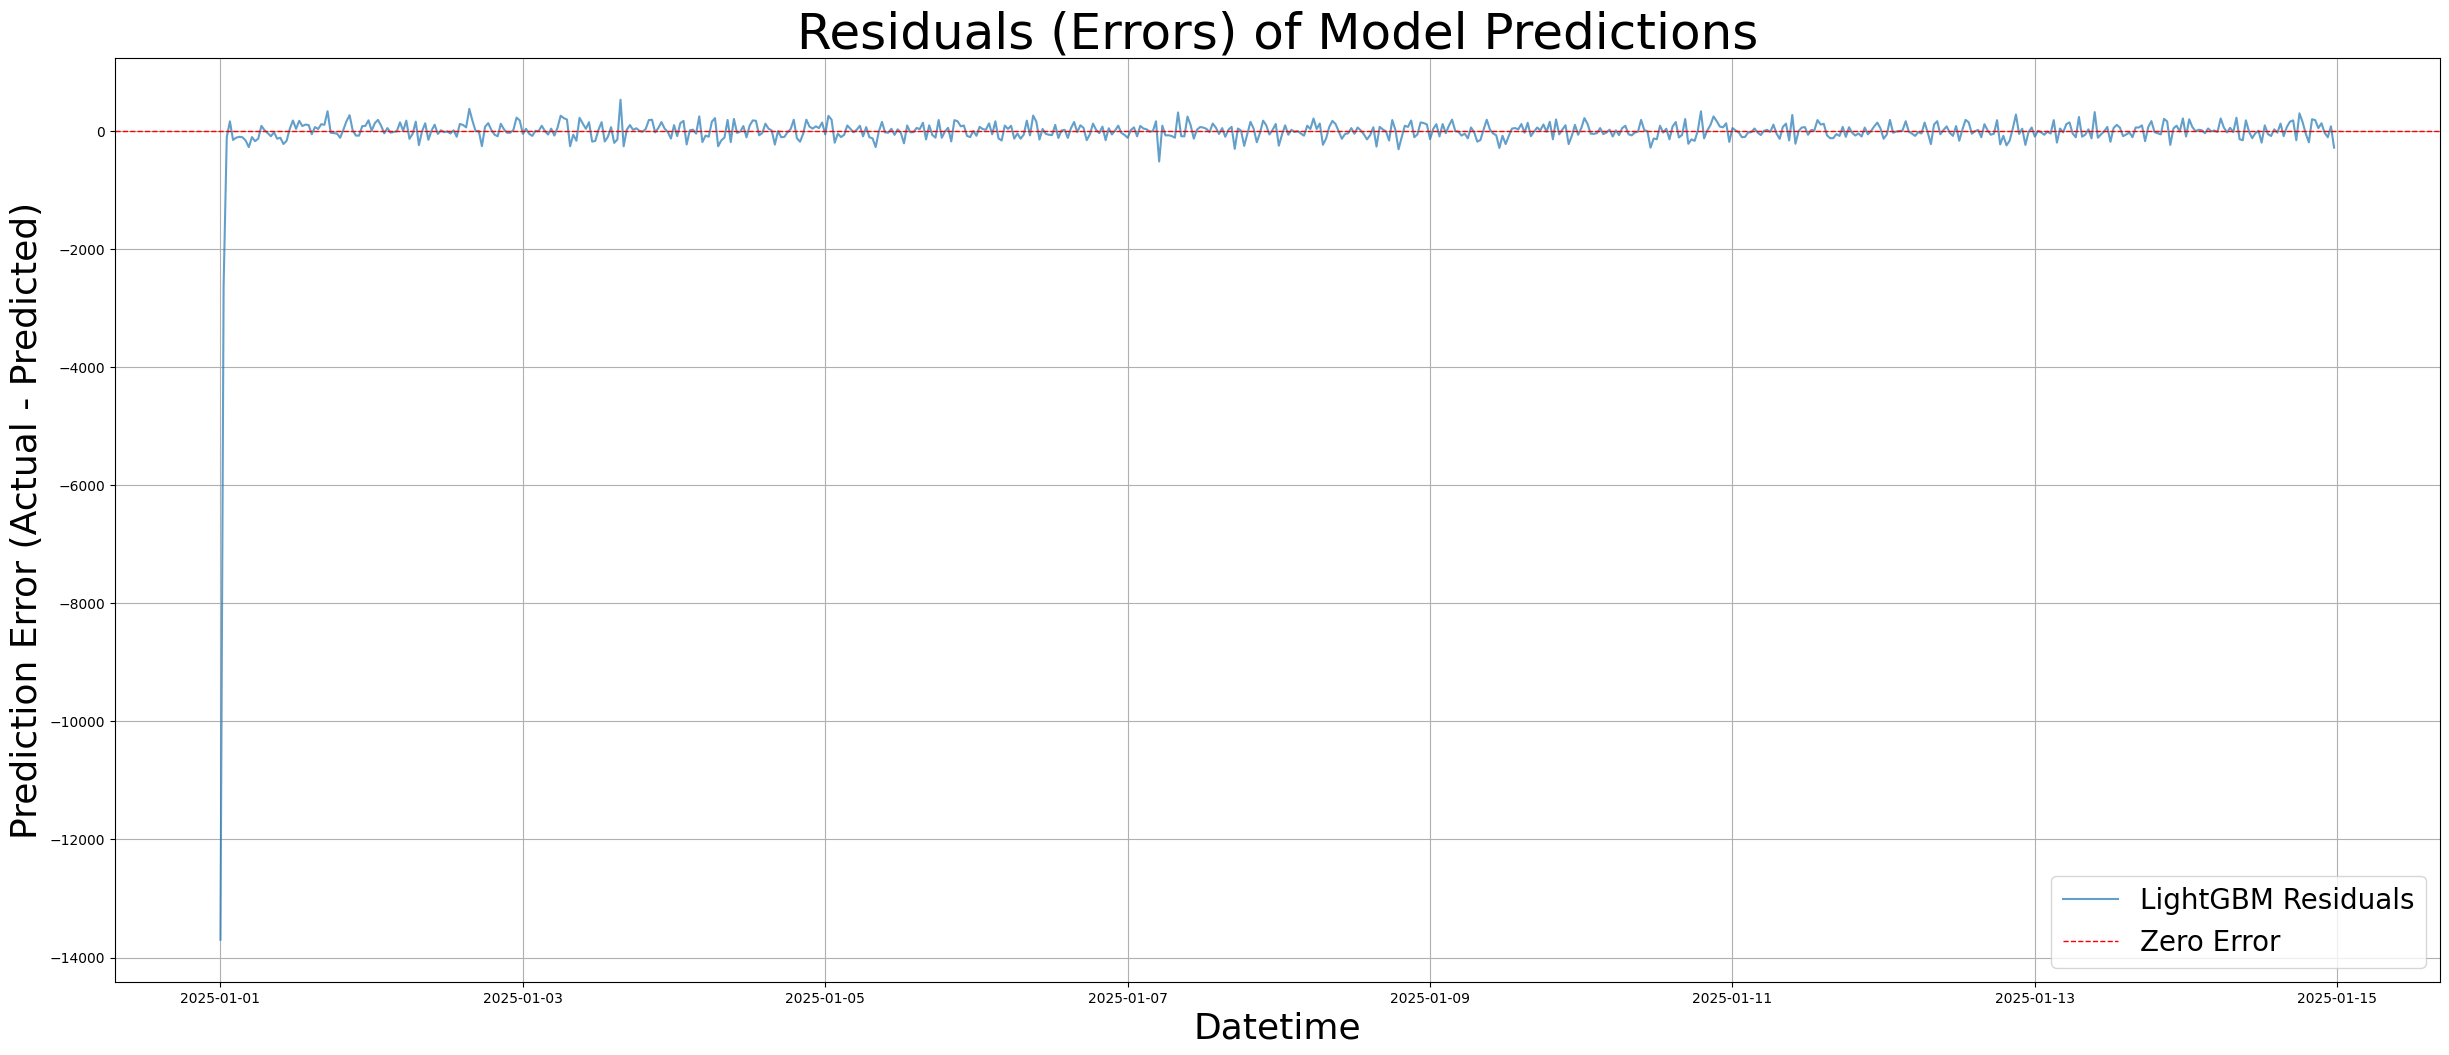

In [22]:
# --- Option 2: Plot the Residuals (Errors) ---
plt.figure(figsize=(30, 12))

# Calculate residuals for each model
residuals_lasso = y_test_pred01 - Lasso_model.flatten() # .flatten() if prediction is 2D
residuals_elasticnet = y_test_pred01 - ElasticNet_model.flatten()
residuals_rf = y_test_pred01 - rf_model.flatten()
residuals_lightgb = y_test_pred01 - LightGB_model.flatten() # Assuming LightGB_model exists

# plt.plot(y_test_pred01.index, residuals_lasso, label='Lasso Residuals', alpha=0.7)
# plt.plot(y_test_pred01.index, residuals_elasticnet, label='ElasticNet Residuals', alpha=0.7)
# plt.plot(y_test_pred01.index, residuals_rf, label='Random Forest Residuals', alpha=0.7)
plt.plot(y_test_pred01.index, residuals_lightgb, label='LightGBM Residuals', alpha=0.7)

plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Error') # Reference line

plt.title('Residuals (Errors) of Model Predictions', fontsize=36)
plt.xlabel('Datetime', fontsize=26)
plt.ylabel('Prediction Error (Actual - Predicted)', fontsize=26)
plt.legend(fontsize=20)
plt.grid(True)
plt.show()